# UNet model

Running the UNet from here 

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import sampler
import skorch
import torchvision.datasets as dset
import torchvision.models as models
import collections
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import torchvision.transforms as transforms
from tqdm import tqdm

%matplotlib inline

from optparse import OptionParser
from unet import UNet
from utils import *
from myloss import dice_coeff


import numpy as np
import matplotlib
# matplotlib.use('agg')
import matplotlib.pyplot as plt
from UNet_Loader import ILDDataset

ModuleNotFoundError: No module named 'skorch'

In [3]:
NUM_TOTAL = 830
NUM_TRAIN = 700

lung_dataset_train = ILDDataset(cystic_path='../Cyst_Dataset/Cystic_masks_new/Train',
                          root_dir='../Cyst_Dataset/Train',
                          mask=True, HU=True, resize=512)

lung_dataset_test = ILDDataset(cystic_path='../Cyst_Dataset/Cystic_masks_new/Test',
                          root_dir='../Cyst_Dataset/Test',
                          mask=True, HU=True, resize=512)

loader_train = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN)))

loader_val = DataLoader(lung_dataset_train, batch_size=4, 
                          sampler=sampler.SubsetRandomSampler(range(NUM_TRAIN, NUM_TOTAL)))

loader_test = DataLoader(lung_dataset_test, batch_size=4)

In [4]:
USE_GPU = True

dtype = torch.float32 # we will be using float throughout this tutorial

if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

# Constant to control how frequently we print train loss
print_every = 100

print('using device:', device)

using device: cuda


# Check Accuracy

In [5]:
def dice_loss(pred, target):
    """This definition generalize to real valued pred and target vector.
    This should be differentiable.
    pred: tensor with first dimension as batch
    target: tensor with first dimension as batch
    """
    
    smooth = 1.

    # have to use contiguous since they may from a torch.view op
    iflat = pred.contiguous().view(-1)
    tflat = target.contiguous().view(-1)
    intersection = (iflat * tflat).sum()

    A_sum = torch.sum(tflat * iflat)
    B_sum = torch.sum(tflat * tflat)
    
    return 1 - ((2. * intersection + smooth) / (A_sum + B_sum + smooth) )

In [6]:
def eval_net(net, loader, device, gpu=True):
    if loader.dataset.train:
        print('Checking accuracy on training set')
    else:
        print('Checking accuracy on test set')   

    tot = 0
    cntr = 0
    net.eval()
    with torch.no_grad():
        for X, y in loader:
            X = X.to(device=device, dtype=torch.float32)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=torch.float32)

            if gpu:
                net.cuda()
                X = Variable(X, requires_grad=True).cuda()
                y = Variable(y, requires_grad=True).cuda()
            else:
                X = Variable(X, requires_grad=True)
                y = Variable(y, requires_grad=True)

            X.unsqueeze_(1)
            y.unsqueeze_(1)
            y_pred = net(X)

            y_pred = (F.sigmoid(y_pred) > 0.5).float()
#             dice = dice_coeff(y_pred, y.float()).data[0]
            dice = dice_loss(y_pred, y)
            tot += dice
            cntr += 1
            
            if 0:
                X = X.data.squeeze(1).cpu().numpy()
                print('X', X.shape)
                X = np.transpose(X, axes=[1, 2, 0])
                print('X.T', X.shape)
                y = y.data.squeeze(1).cpu().numpy()
                print('y', y.shape)
                y = np.transpose(y, axes=[1, 2, 0])
                print('y.T', y.shape)
                y_pred = y_pred.data.squeeze(1).squeeze(1).cpu().numpy()
                y_pred = np.transpose(y_pred, axes=[1, 2, 0])
                print(y_pred.shape)

                fig = plt.figure()
                ax1 = fig.add_subplot(1, 4, 1)
                ax1.imshow(X)
                ax2 = fig.add_subplot(1, 4, 2)
                ax2.imshow(y)
                ax3 = fig.add_subplot(1, 4, 3)
                ax3.imshow((y_pred > 0.5))
                
                y_pred = np.transpose(y_pred, axes=[2, 0, 1])
                Q = dense_crf(((X[0] * 255).round()).astype(np.uint8), y_pred[0])
                ax4 = fig.add_subplot(1, 4, 4)
                print(Q)
                ax4.imshow(Q > 0.5)
                plt.show()
    return tot / cntr

# Train

In [9]:
#Train function

def train_net(net, epochs=50, batch_size=4, lr=1e-3, save=True, gpu=True):
    optimizer = optim.Adam(net.parameters(), lr=lr, weight_decay=0.0005, amsgrad=True)
    criterion = nn.BCELoss()
    dir_checkpoint = 'checkpoints/'
    
    all_losses = []
    for epoch in range(epochs):
        print('Starting epoch {}/{}.'.format(epoch + 1, epochs))

        epoch_loss = 0
            
        for t, (X, y) in enumerate(loader_train):
            X = X.to(device=device, dtype=dtype)  # move to device, e.g. GPU
            y = y.to(device=device, dtype=dtype)
            X.unsqueeze_(1)
            y.unsqueeze_(1)

            if gpu:
                net.cuda()
                X = Variable(X).cuda()
                y = Variable(y).cuda()
            else:
                X = Variable(X)
                y = Variable(y)
            
            
            y_pred = net(X)
#             print(y_pred.shape)
            
            probs = F.sigmoid(y_pred)
            probs_flat = probs.view(-1)
            y_pred_print = (probs > 0.5)

            y_flat = y.view(-1)

            loss = criterion(probs_flat, y_flat.float())
            all_losses.append(loss)
            epoch_loss += loss.data[0]

            if(t%100 == 0):
                print('{0:.4f} --- loss: {1:.6f}'.format(t,
                                                     loss.data[0]))
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
                
        print('Epoch finished ! Loss: {}'.format(epoch_loss / t))
        
        if 1:
            val_dice = eval_net(net, loader_val, device, gpu)
            print('Validation Dice Coeff: {}'.format(val_dice))
            
            print("X")
            plt.imshow(X.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Predicted Y")
            plt.imshow(y_pred.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Probs Y")
            plt.imshow(y_pred_print.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()
            print("Actual Y")
            plt.imshow(y.data.cpu().numpy()[0,0,:], cmap='gray')
            plt.show()

        if save:
            torch.save(net.state_dict(),
                       dir_checkpoint + '/adam/CP{}.pth'.format(epoch + 1))

            print('Checkpoint {} saved !'.format(epoch + 1))
            
    return all_losses


Starting epoch 1/50.
0.0000 --- loss: 0.726735
100.0000 --- loss: 0.123691
Epoch finished ! Loss: 0.2266642302274704
Checking accuracy on test set
Validation Dice Coeff: 0.6561040878295898
X


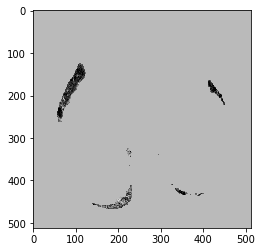

Predicted Y


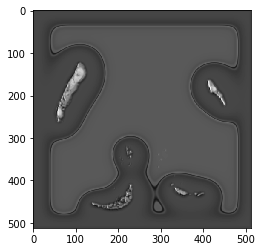

Probs Y


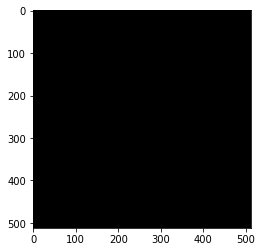

Actual Y


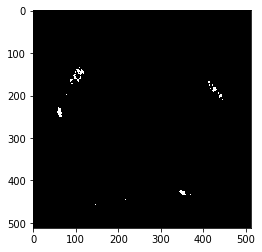

Checkpoint 1 saved !
Starting epoch 2/50.
0.0000 --- loss: 0.063842
100.0000 --- loss: 0.006196
Epoch finished ! Loss: 0.025534572079777718
Checking accuracy on test set
Validation Dice Coeff: 0.7163342237472534
X


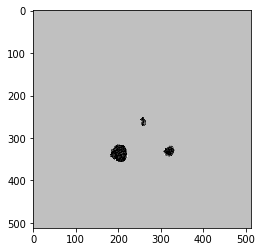

Predicted Y


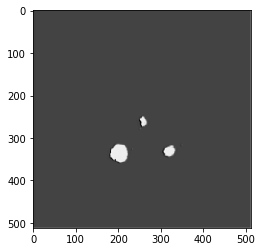

Probs Y


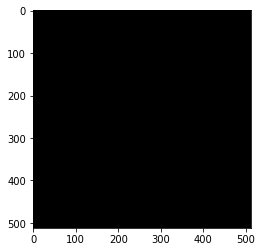

Actual Y


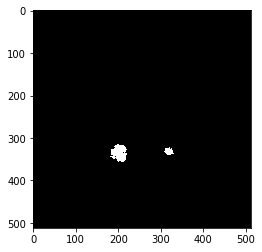

Checkpoint 2 saved !
Starting epoch 3/50.
0.0000 --- loss: 0.046206
100.0000 --- loss: 0.024357
Epoch finished ! Loss: 0.024973327293992043
Checking accuracy on test set
Validation Dice Coeff: 0.7568359971046448
X


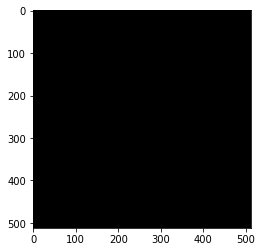

Predicted Y


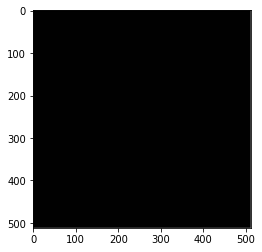

Probs Y


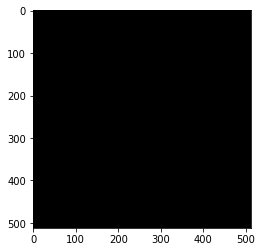

Actual Y


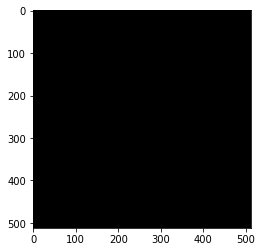

Checkpoint 3 saved !
Starting epoch 4/50.
0.0000 --- loss: 0.010089
100.0000 --- loss: 0.009585
Epoch finished ! Loss: 0.02499251440167427
Checking accuracy on test set
Validation Dice Coeff: 0.6657283902168274
X


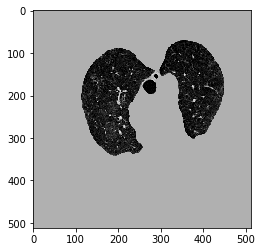

Predicted Y


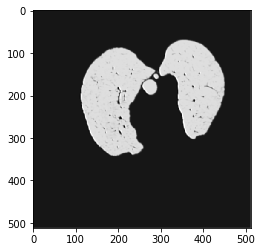

Probs Y


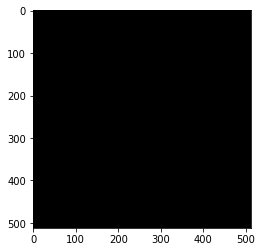

Actual Y


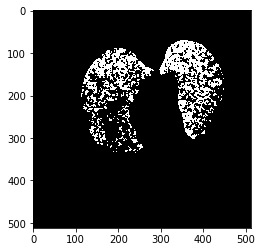

Checkpoint 4 saved !
Starting epoch 5/50.
0.0000 --- loss: 0.006470
100.0000 --- loss: 0.005812
Epoch finished ! Loss: 0.024154923856258392
Checking accuracy on test set
Validation Dice Coeff: 0.7261770963668823
X


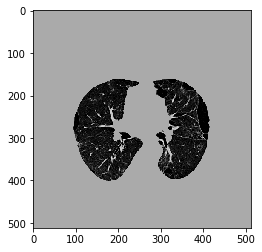

Predicted Y


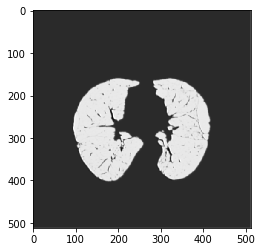

Probs Y


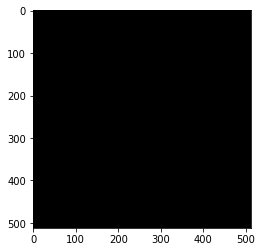

Actual Y


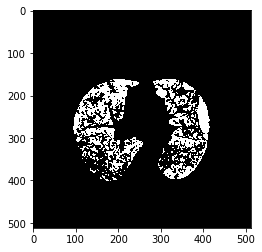

Checkpoint 5 saved !
Starting epoch 6/50.
0.0000 --- loss: 0.069602
100.0000 --- loss: 0.002666
Epoch finished ! Loss: 0.02506576105952263
Checking accuracy on test set
Validation Dice Coeff: 0.6859959363937378
X


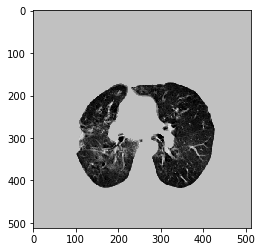

Predicted Y


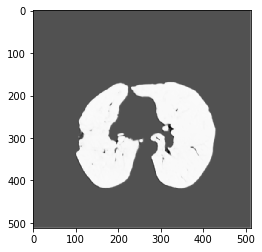

Probs Y


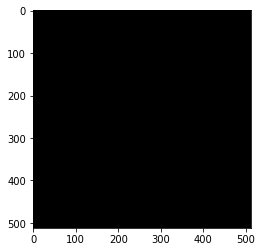

Actual Y


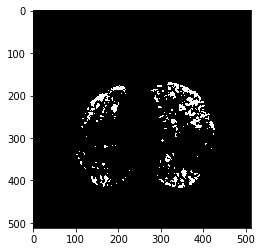

Checkpoint 6 saved !
Starting epoch 7/50.
0.0000 --- loss: 0.005560
100.0000 --- loss: 0.032867
Epoch finished ! Loss: 0.024562817066907883
Checking accuracy on test set
Validation Dice Coeff: 0.6660597324371338
X


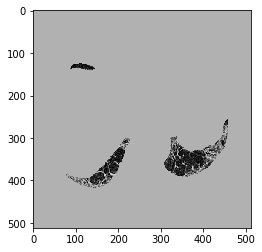

Predicted Y


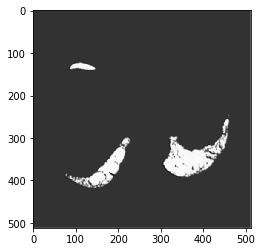

Probs Y


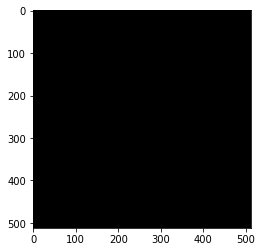

Actual Y


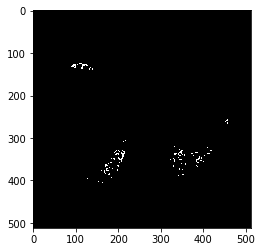

Checkpoint 7 saved !
Starting epoch 8/50.
0.0000 --- loss: 0.097941
100.0000 --- loss: 0.028797
Epoch finished ! Loss: 0.02396535873413086
Checking accuracy on test set
Validation Dice Coeff: 0.6259279251098633
X


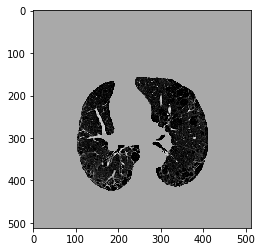

Predicted Y


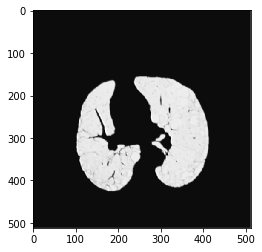

Probs Y


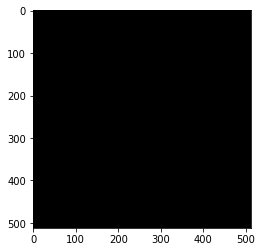

Actual Y


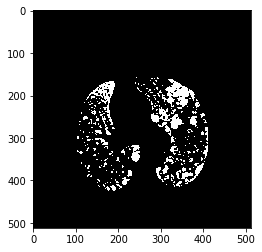

Checkpoint 8 saved !
Starting epoch 9/50.
0.0000 --- loss: 0.063908
100.0000 --- loss: 0.010636
Epoch finished ! Loss: 0.024412566795945168
Checking accuracy on test set
Validation Dice Coeff: 0.6361823081970215
X


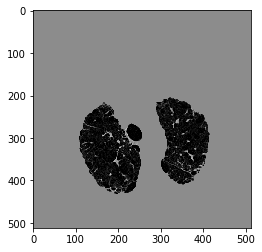

Predicted Y


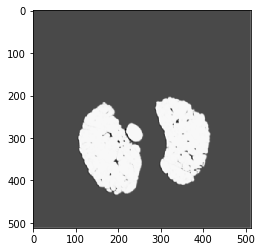

Probs Y


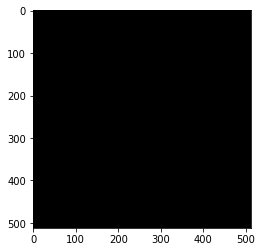

Actual Y


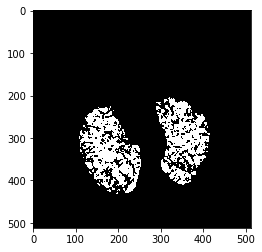

Checkpoint 9 saved !
Starting epoch 10/50.
0.0000 --- loss: 0.027737
100.0000 --- loss: 0.075107
Epoch finished ! Loss: 0.02390793338418007
Checking accuracy on test set
Validation Dice Coeff: 0.6058869361877441
X


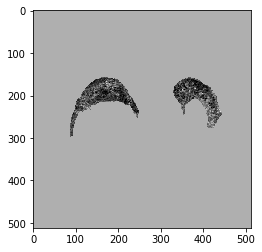

Predicted Y


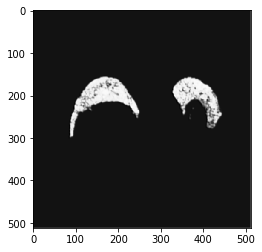

Probs Y


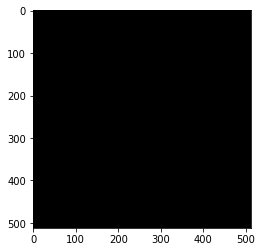

Actual Y


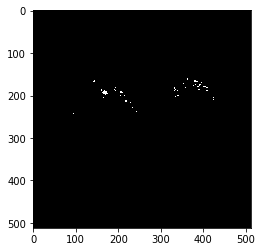

Checkpoint 10 saved !
Starting epoch 11/50.
0.0000 --- loss: 0.024124
100.0000 --- loss: 0.027827
Epoch finished ! Loss: 0.024169696494936943
Checking accuracy on test set
Validation Dice Coeff: 0.6261273622512817
X


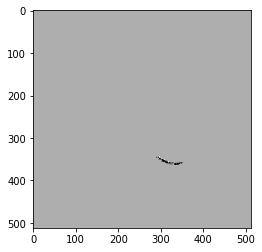

Predicted Y


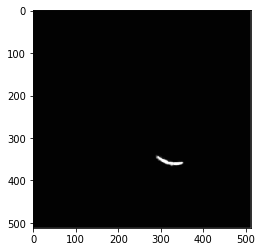

Probs Y


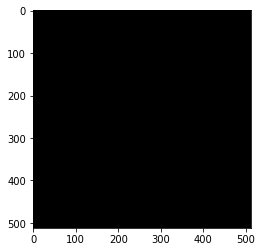

Actual Y


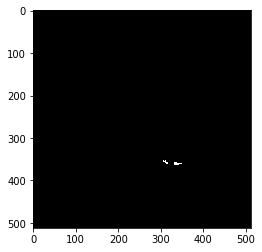

Checkpoint 11 saved !
Starting epoch 12/50.
0.0000 --- loss: 0.015642
100.0000 --- loss: 0.003921
Epoch finished ! Loss: 0.024085376411676407
Checking accuracy on test set
Validation Dice Coeff: 0.6865447163581848
X


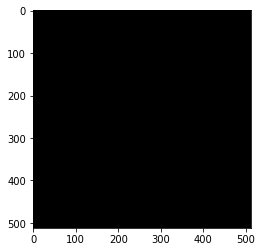

Predicted Y


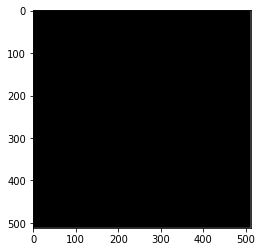

Probs Y


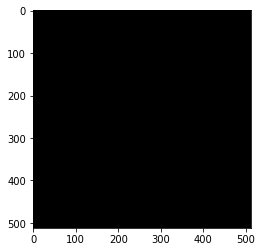

Actual Y


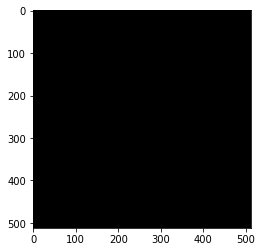

Checkpoint 12 saved !
Starting epoch 13/50.
0.0000 --- loss: 0.011372
100.0000 --- loss: 0.027451
Epoch finished ! Loss: 0.024099819362163544
Checking accuracy on test set
Validation Dice Coeff: 0.696491539478302
X


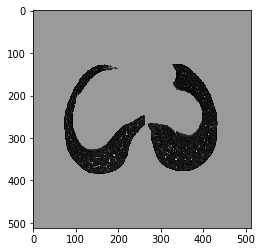

Predicted Y


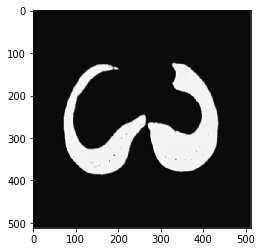

Probs Y


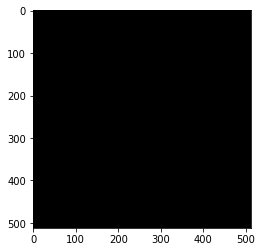

Actual Y


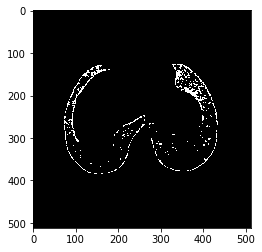

Checkpoint 13 saved !
Starting epoch 14/50.
0.0000 --- loss: 0.044540
100.0000 --- loss: 0.019785
Epoch finished ! Loss: 0.02376348339021206
Checking accuracy on test set
Validation Dice Coeff: 0.7267364859580994
X


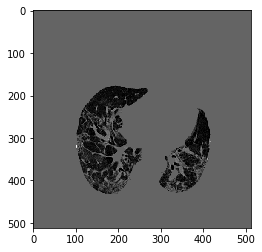

Predicted Y


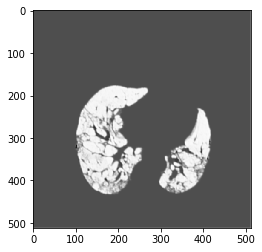

Probs Y


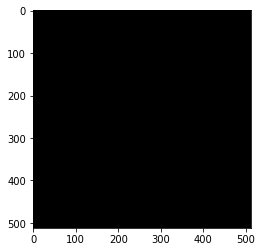

Actual Y


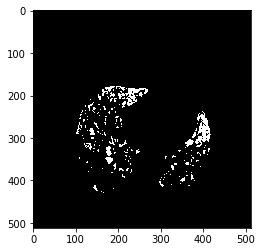

Checkpoint 14 saved !
Starting epoch 15/50.
0.0000 --- loss: 0.001644
100.0000 --- loss: 0.030022
Epoch finished ! Loss: 0.024106258526444435
Checking accuracy on test set
Validation Dice Coeff: 0.7268171906471252
X


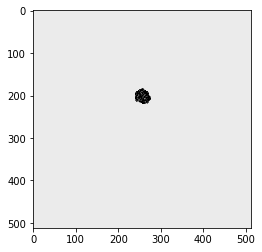

Predicted Y


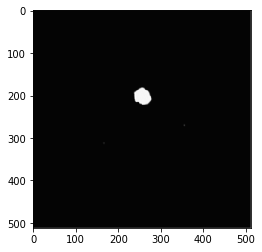

Probs Y


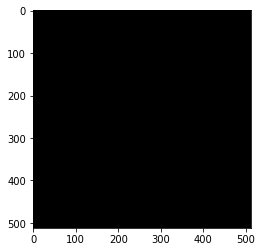

Actual Y


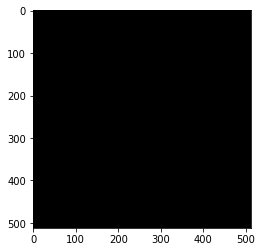

Checkpoint 15 saved !
Starting epoch 16/50.
0.0000 --- loss: 0.029194
100.0000 --- loss: 0.082506
Epoch finished ! Loss: 0.02385341376066208
Checking accuracy on test set
Validation Dice Coeff: 0.6659275889396667
X


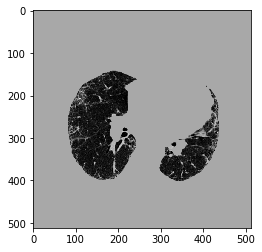

Predicted Y


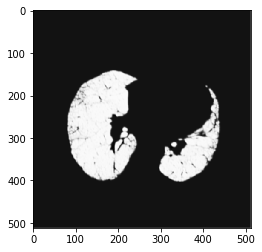

Probs Y


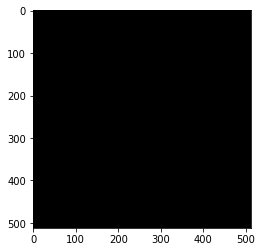

Actual Y


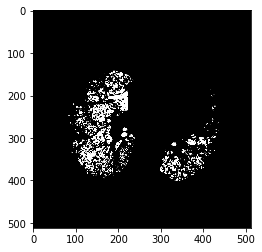

Checkpoint 16 saved !
Starting epoch 17/50.
0.0000 --- loss: 0.023493
100.0000 --- loss: 0.008333
Epoch finished ! Loss: 0.023622898384928703
Checking accuracy on test set
Validation Dice Coeff: 0.6963047981262207
X


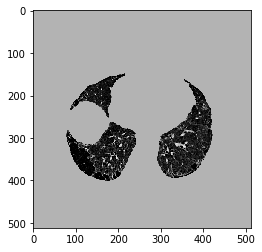

Predicted Y


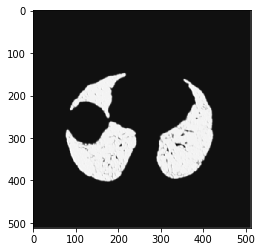

Probs Y


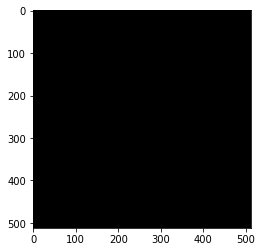

Actual Y


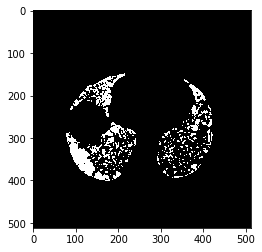

Checkpoint 17 saved !
Starting epoch 18/50.
0.0000 --- loss: 0.007734
100.0000 --- loss: 0.089964
Epoch finished ! Loss: 0.023411525413393974
Checking accuracy on test set
Validation Dice Coeff: 0.6660037636756897
X


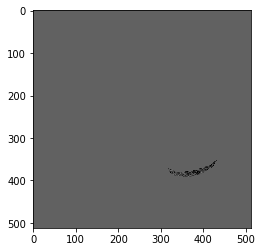

Predicted Y


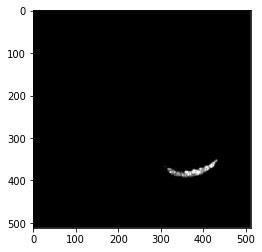

Probs Y


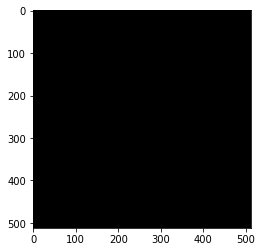

Actual Y


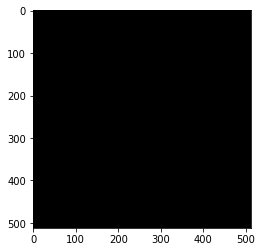

Checkpoint 18 saved !
Starting epoch 19/50.
0.0000 --- loss: 0.019647
100.0000 --- loss: 0.028338
Epoch finished ! Loss: 0.023453794419765472
Checking accuracy on test set
Validation Dice Coeff: 0.7567951083183289
X


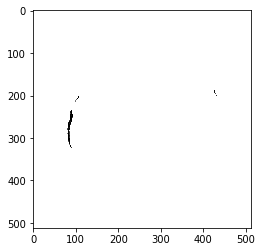

Predicted Y


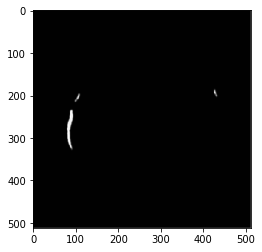

Probs Y


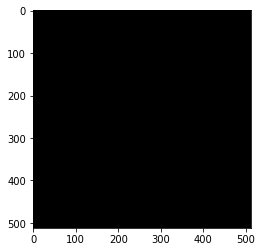

Actual Y


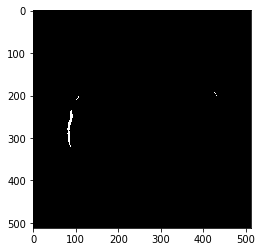

Checkpoint 19 saved !
Starting epoch 20/50.
0.0000 --- loss: 0.003274
100.0000 --- loss: 0.004414
Epoch finished ! Loss: 0.02392643690109253
Checking accuracy on test set
Validation Dice Coeff: 0.8175802230834961
X


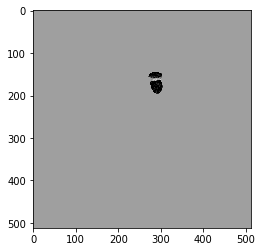

Predicted Y


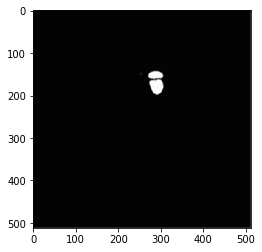

Probs Y


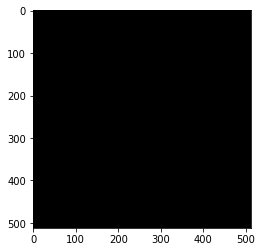

Actual Y


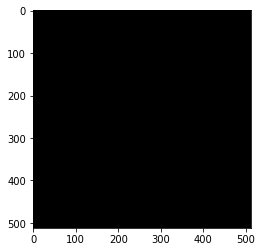

Checkpoint 20 saved !
Starting epoch 21/50.
0.0000 --- loss: 0.006992
100.0000 --- loss: 0.009945
Epoch finished ! Loss: 0.024016782641410828
Checking accuracy on test set
Validation Dice Coeff: 0.6965269446372986
X


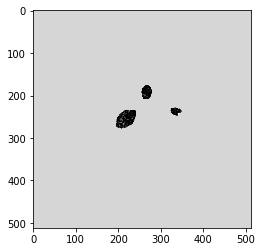

Predicted Y


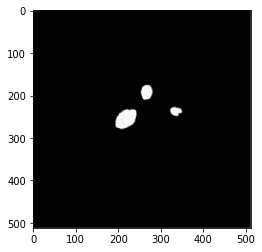

Probs Y


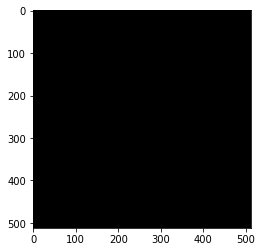

Actual Y


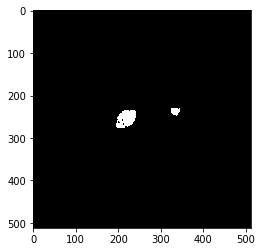

Checkpoint 21 saved !
Starting epoch 22/50.
0.0000 --- loss: 0.005012
100.0000 --- loss: 0.017192
Epoch finished ! Loss: 0.024413930252194405
Checking accuracy on test set
Validation Dice Coeff: 0.7165349721908569
X


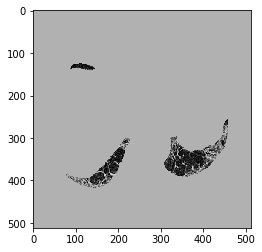

Predicted Y


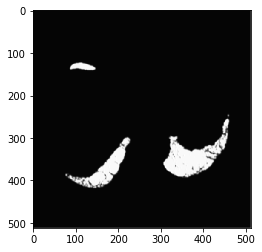

Probs Y


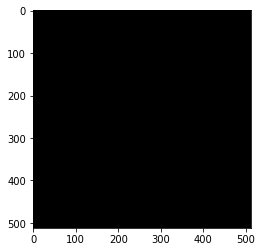

Actual Y


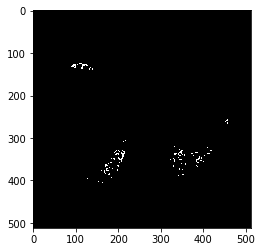

Checkpoint 22 saved !
Starting epoch 23/50.
0.0000 --- loss: 0.008706
100.0000 --- loss: 0.024786
Epoch finished ! Loss: 0.024183982983231544
Checking accuracy on test set
Validation Dice Coeff: 0.8375679850578308
X


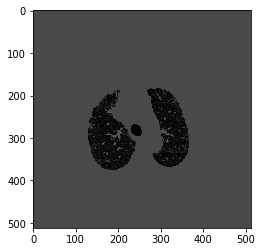

Predicted Y


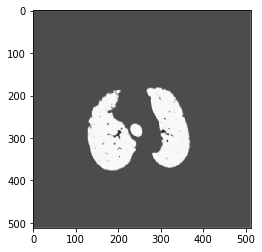

Probs Y


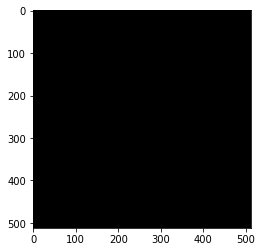

Actual Y


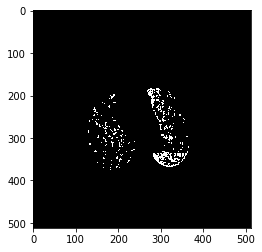

Checkpoint 23 saved !
Starting epoch 24/50.
0.0000 --- loss: 0.008065
100.0000 --- loss: 0.038593
Epoch finished ! Loss: 0.023862307891249657
Checking accuracy on test set
Validation Dice Coeff: 0.6865232586860657
X


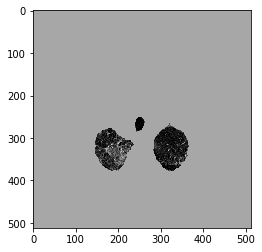

Predicted Y


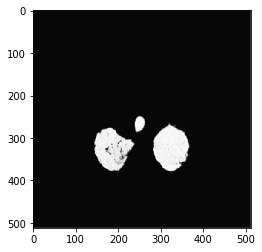

Probs Y


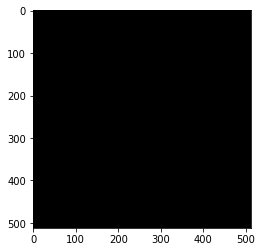

Actual Y


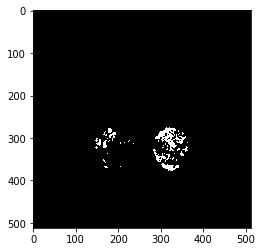

Checkpoint 24 saved !
Starting epoch 25/50.
0.0000 --- loss: 0.045240
100.0000 --- loss: 0.002591
Epoch finished ! Loss: 0.023595677688717842
Checking accuracy on test set
Validation Dice Coeff: 0.787307858467102
X


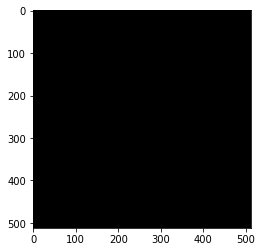

Predicted Y


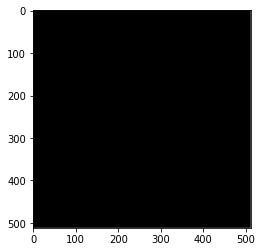

Probs Y


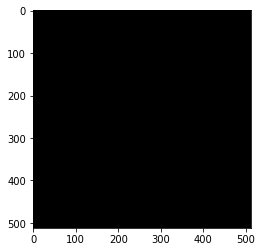

Actual Y


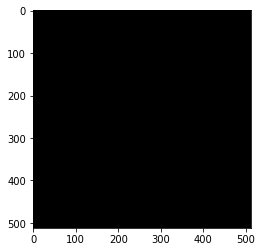

Checkpoint 25 saved !
Starting epoch 26/50.
0.0000 --- loss: 0.024359
100.0000 --- loss: 0.004895
Epoch finished ! Loss: 0.023735038936138153
Checking accuracy on test set
Validation Dice Coeff: 0.6966744661331177
X


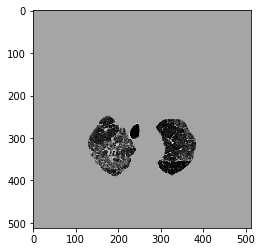

Predicted Y


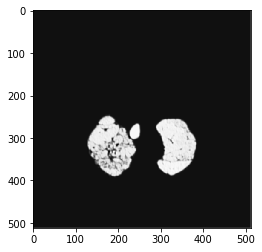

Probs Y


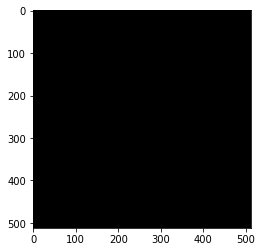

Actual Y


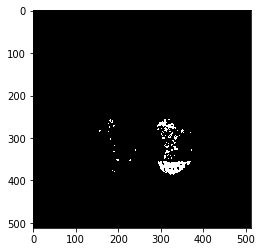

Checkpoint 26 saved !
Starting epoch 27/50.
0.0000 --- loss: 0.019872
100.0000 --- loss: 0.011393
Epoch finished ! Loss: 0.02340245246887207
Checking accuracy on test set
Validation Dice Coeff: 0.7866650223731995
X


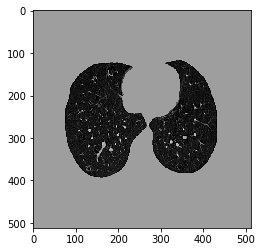

Predicted Y


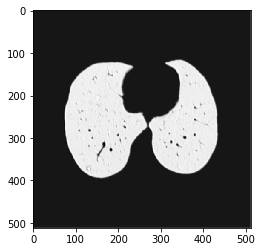

Probs Y


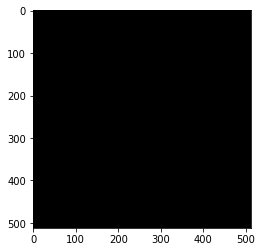

Actual Y


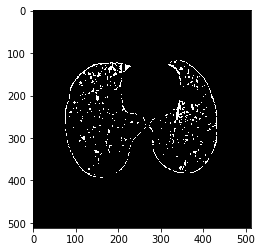

Checkpoint 27 saved !
Starting epoch 28/50.
0.0000 --- loss: 0.012195
100.0000 --- loss: 0.027591
Epoch finished ! Loss: 0.023067887872457504
Checking accuracy on test set
Validation Dice Coeff: 0.7769553661346436
X


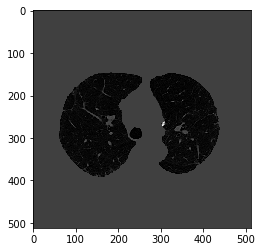

Predicted Y


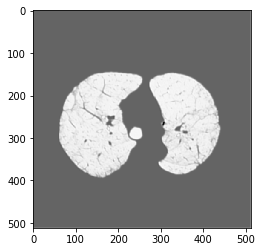

Probs Y


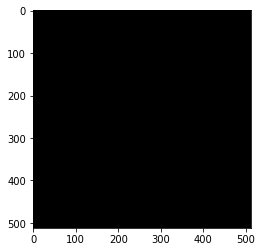

Actual Y


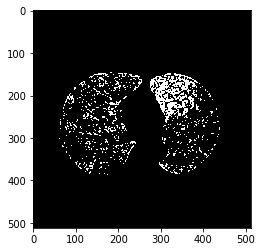

Checkpoint 28 saved !
Starting epoch 29/50.
0.0000 --- loss: 0.003021
100.0000 --- loss: 0.009614
Epoch finished ! Loss: 0.023107079789042473
Checking accuracy on test set
Validation Dice Coeff: 0.6358871459960938
X


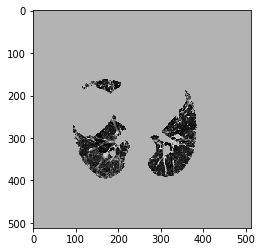

Predicted Y


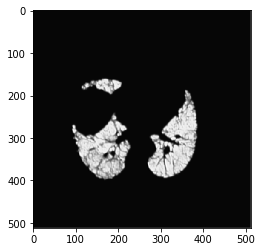

Probs Y


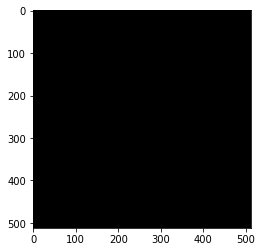

Actual Y


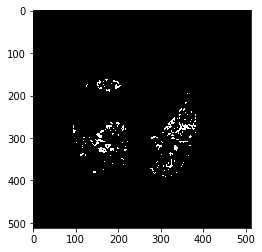

Checkpoint 29 saved !
Starting epoch 30/50.
0.0000 --- loss: 0.023963
100.0000 --- loss: 0.037731
Epoch finished ! Loss: 0.024055523797869682
Checking accuracy on test set
Validation Dice Coeff: 0.6860092878341675
X


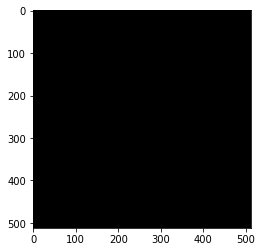

Predicted Y


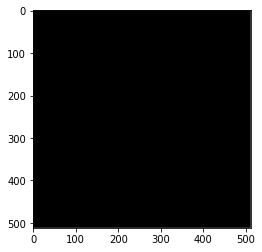

Probs Y


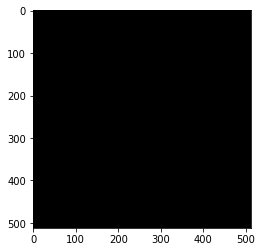

Actual Y


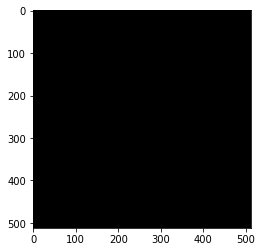

Checkpoint 30 saved !
Starting epoch 31/50.
0.0000 --- loss: 0.012491
100.0000 --- loss: 0.019694
Epoch finished ! Loss: 0.023789331316947937
Checking accuracy on test set
Validation Dice Coeff: 0.7164065837860107
X


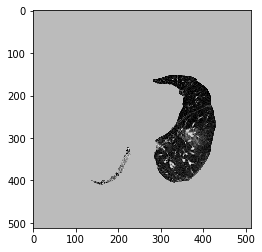

Predicted Y


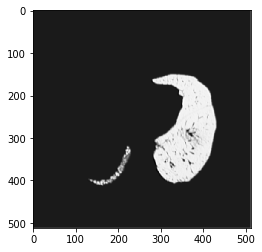

Probs Y


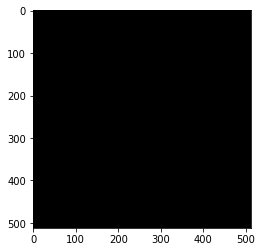

Actual Y


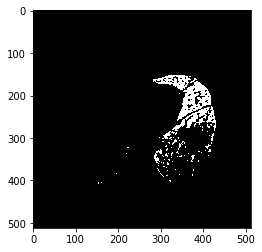

Checkpoint 31 saved !
Starting epoch 32/50.
0.0000 --- loss: 0.004058
100.0000 --- loss: 0.031974
Epoch finished ! Loss: 0.02324829064309597
Checking accuracy on test set
Validation Dice Coeff: 0.8072006702423096
X


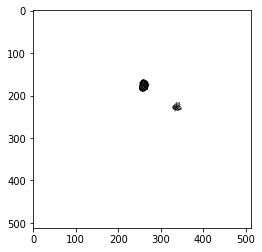

Predicted Y


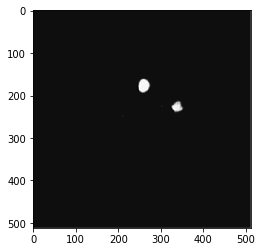

Probs Y


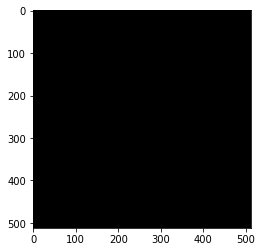

Actual Y


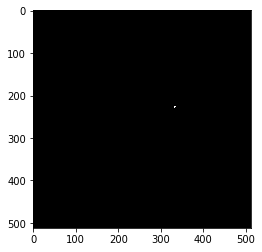

Checkpoint 32 saved !
Starting epoch 33/50.
0.0000 --- loss: 0.083238
100.0000 --- loss: 0.004186
Epoch finished ! Loss: 0.02276328019797802
Checking accuracy on test set
Validation Dice Coeff: 0.7163515686988831
X


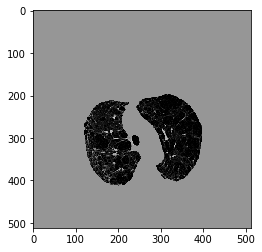

Predicted Y


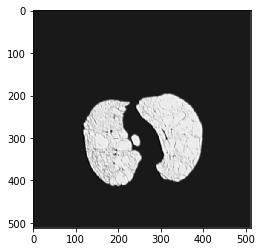

Probs Y


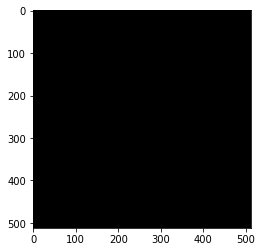

Actual Y


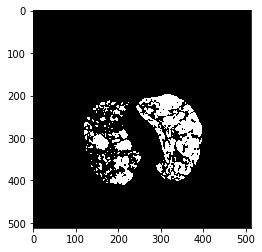

Checkpoint 33 saved !
Starting epoch 34/50.
0.0000 --- loss: 0.036557
100.0000 --- loss: 0.011197
Epoch finished ! Loss: 0.023117605596780777
Checking accuracy on test set
Validation Dice Coeff: 0.7567062973976135
X


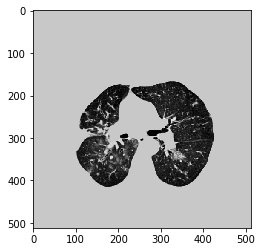

Predicted Y


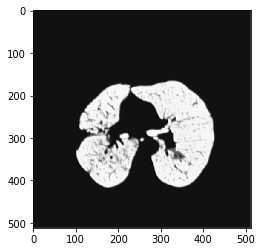

Probs Y


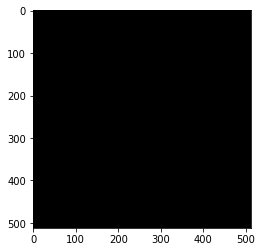

Actual Y


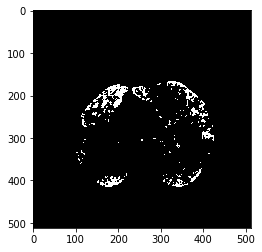

Checkpoint 34 saved !
Starting epoch 35/50.
0.0000 --- loss: 0.018160
100.0000 --- loss: 0.006472
Epoch finished ! Loss: 0.02262953855097294
Checking accuracy on test set
Validation Dice Coeff: 0.6056997776031494
X


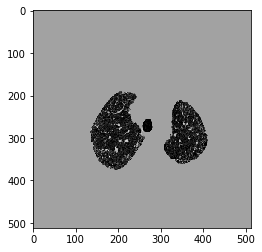

Predicted Y


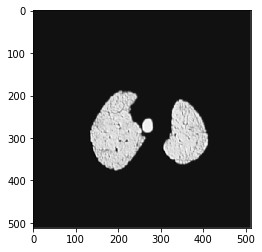

Probs Y


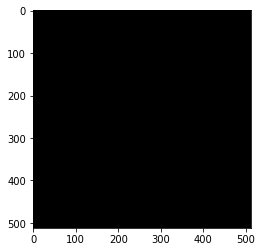

Actual Y


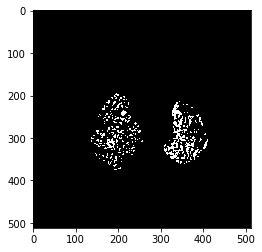

Checkpoint 35 saved !
Starting epoch 36/50.
0.0000 --- loss: 0.008052
100.0000 --- loss: 0.003517
Epoch finished ! Loss: 0.02340570278465748
Checking accuracy on test set
Validation Dice Coeff: 0.7269032001495361
X


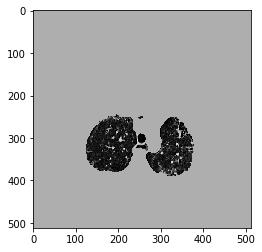

Predicted Y


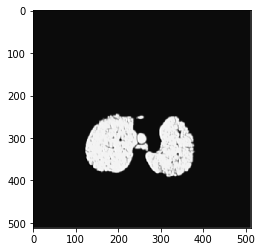

Probs Y


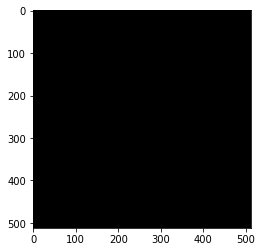

Actual Y


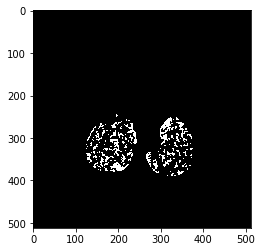

Checkpoint 36 saved !
Starting epoch 37/50.
0.0000 --- loss: 0.010262
100.0000 --- loss: 0.005421
Epoch finished ! Loss: 0.022464364767074585
Checking accuracy on test set
Validation Dice Coeff: 0.746656596660614
X


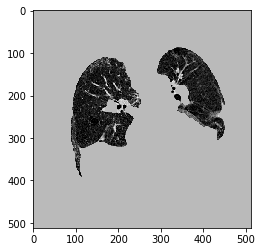

Predicted Y


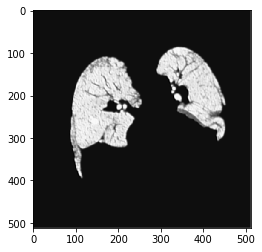

Probs Y


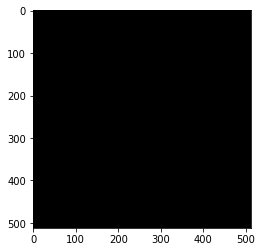

Actual Y


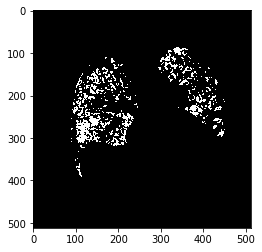

Checkpoint 37 saved !
Starting epoch 38/50.
0.0000 --- loss: 0.025461
100.0000 --- loss: 0.009387
Epoch finished ! Loss: 0.02277563512325287
Checking accuracy on test set
Validation Dice Coeff: 0.7268221378326416
X


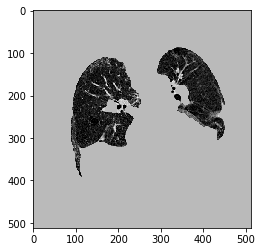

Predicted Y


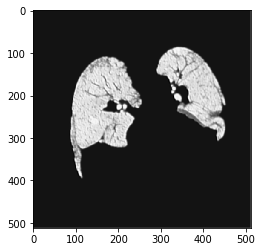

Probs Y


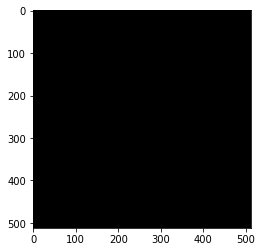

Actual Y


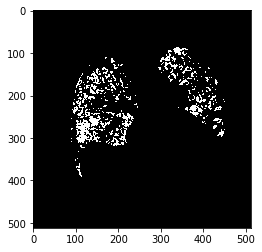

Checkpoint 38 saved !
Starting epoch 39/50.
0.0000 --- loss: 0.011306
100.0000 --- loss: 0.001385
Epoch finished ! Loss: 0.022396240383386612
Checking accuracy on test set
Validation Dice Coeff: 0.6864674091339111
X


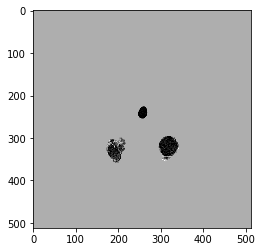

Predicted Y


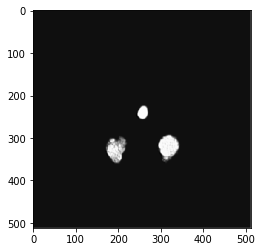

Probs Y


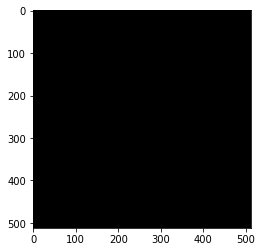

Actual Y


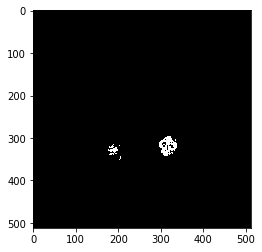

Checkpoint 39 saved !
Starting epoch 40/50.
0.0000 --- loss: 0.008387
100.0000 --- loss: 0.004922
Epoch finished ! Loss: 0.022485846653580666
Checking accuracy on test set
Validation Dice Coeff: 0.6866546869277954
X


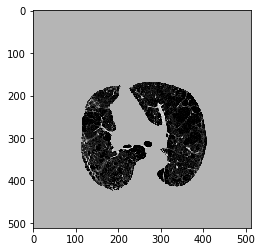

Predicted Y


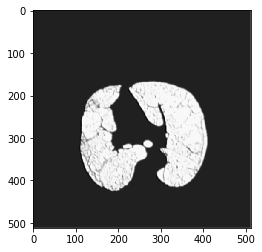

Probs Y


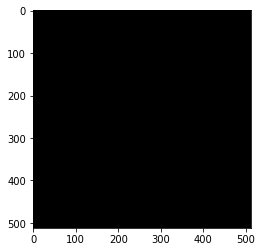

Actual Y


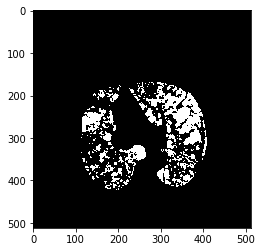

Checkpoint 40 saved !
Starting epoch 41/50.
0.0000 --- loss: 0.029834
100.0000 --- loss: 0.003314
Epoch finished ! Loss: 0.02237917296588421
Checking accuracy on test set
Validation Dice Coeff: 0.6965567469596863
X


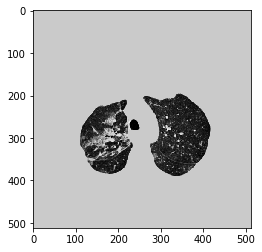

Predicted Y


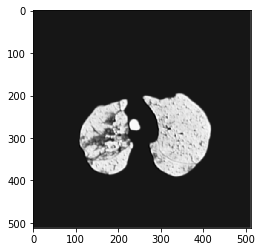

Probs Y


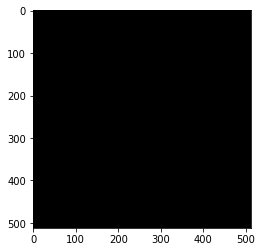

Actual Y


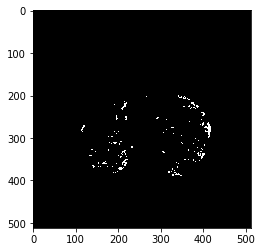

Checkpoint 41 saved !
Starting epoch 42/50.
0.0000 --- loss: 0.038373
100.0000 --- loss: 0.037569
Epoch finished ! Loss: 0.022135090082883835
Checking accuracy on test set
Validation Dice Coeff: 0.7770034074783325
X


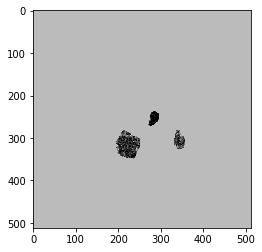

Predicted Y


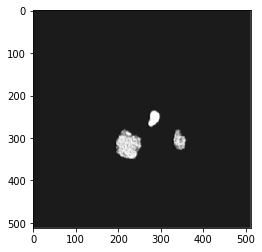

Probs Y


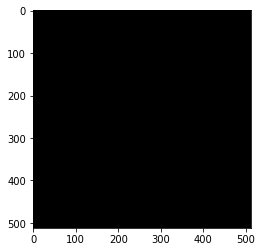

Actual Y


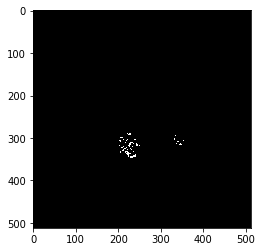

Checkpoint 42 saved !
Starting epoch 43/50.
0.0000 --- loss: 0.007803
100.0000 --- loss: 0.010748
Epoch finished ! Loss: 0.02260231226682663
Checking accuracy on test set
Validation Dice Coeff: 0.7262686491012573
X


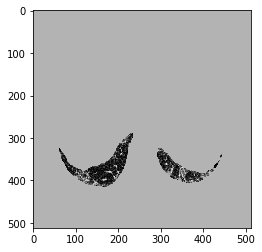

Predicted Y


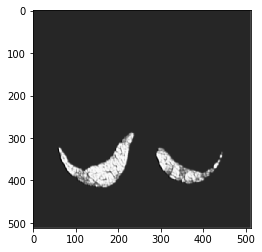

Probs Y


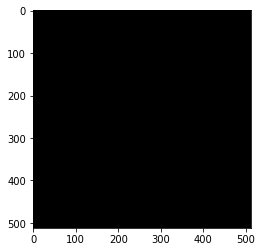

Actual Y


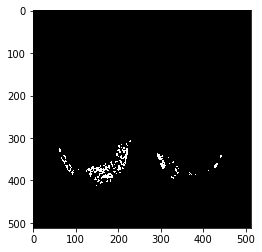

Checkpoint 43 saved !
Starting epoch 44/50.
0.0000 --- loss: 0.003788
100.0000 --- loss: 0.013451
Epoch finished ! Loss: 0.022023631259799004
Checking accuracy on test set
Validation Dice Coeff: 0.7166680097579956
X


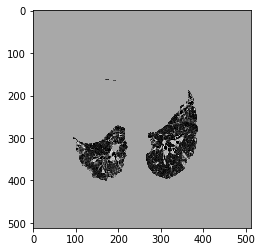

Predicted Y


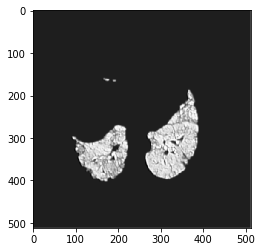

Probs Y


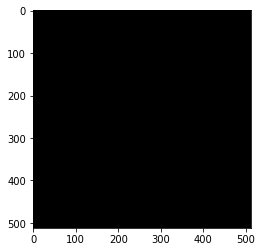

Actual Y


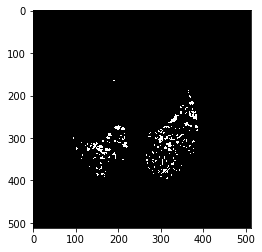

Checkpoint 44 saved !
Starting epoch 45/50.
0.0000 --- loss: 0.066006
100.0000 --- loss: 0.009928
Epoch finished ! Loss: 0.022109800949692726
Checking accuracy on test set
Validation Dice Coeff: 0.665976345539093
X


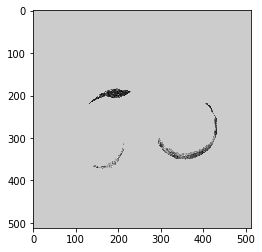

Predicted Y


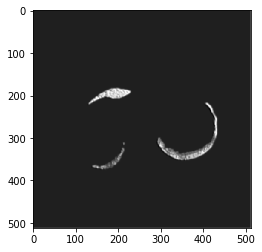

Probs Y


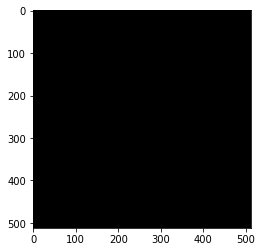

Actual Y


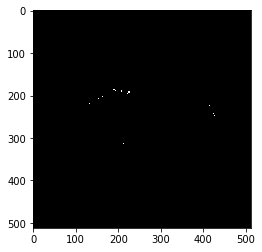

Checkpoint 45 saved !
Starting epoch 46/50.
0.0000 --- loss: 0.071862
100.0000 --- loss: 0.009573
Epoch finished ! Loss: 0.022445110604166985
Checking accuracy on test set
Validation Dice Coeff: 0.7567044496536255
X


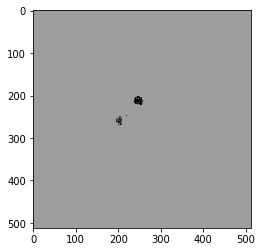

Predicted Y


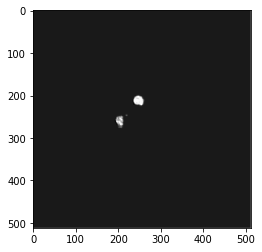

Probs Y


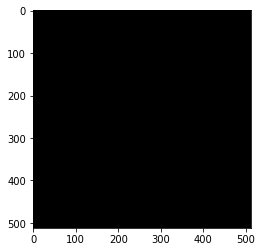

Actual Y


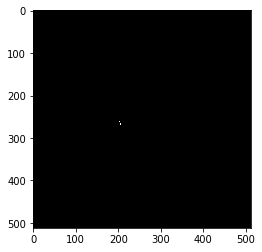

Checkpoint 46 saved !
Starting epoch 47/50.
0.0000 --- loss: 0.020075
100.0000 --- loss: 0.020884
Epoch finished ! Loss: 0.02214556373655796
Checking accuracy on test set
Validation Dice Coeff: 0.7262405753135681
X


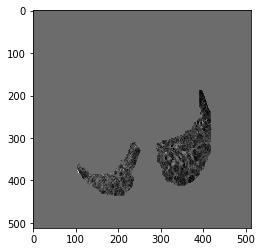

Predicted Y


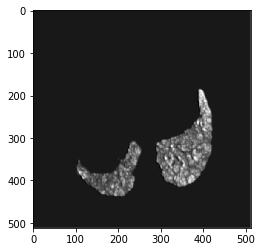

Probs Y


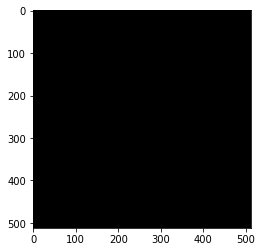

Actual Y


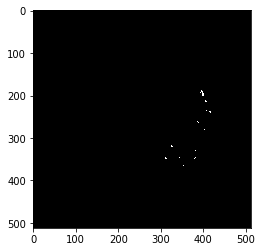

Checkpoint 47 saved !
Starting epoch 48/50.
0.0000 --- loss: 0.087410
100.0000 --- loss: 0.006633
Epoch finished ! Loss: 0.022367609664797783
Checking accuracy on test set
Validation Dice Coeff: 0.7267593145370483
X


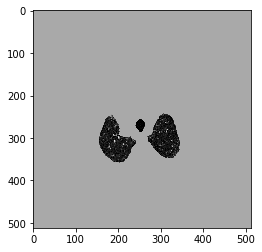

Predicted Y


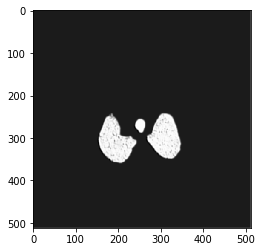

Probs Y


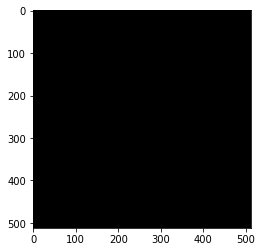

Actual Y


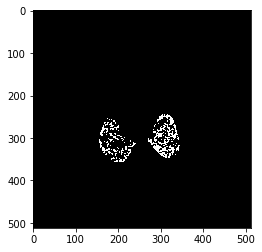

Checkpoint 48 saved !
Starting epoch 49/50.
0.0000 --- loss: 0.003483
100.0000 --- loss: 0.003343
Epoch finished ! Loss: 0.022448258474469185
Checking accuracy on test set
Validation Dice Coeff: 0.7166391611099243
X


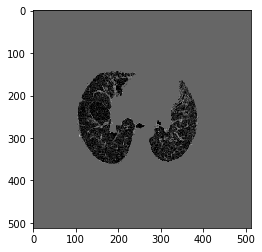

Predicted Y


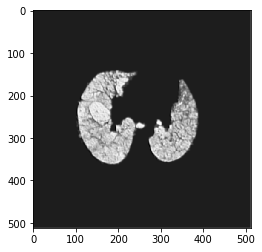

Probs Y


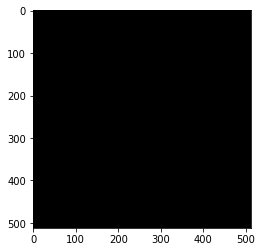

Actual Y


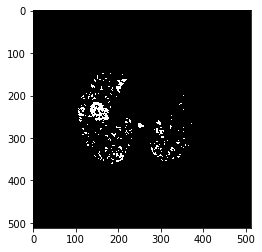

Checkpoint 49 saved !
Starting epoch 50/50.
0.0000 --- loss: 0.035124
100.0000 --- loss: 0.007385
Epoch finished ! Loss: 0.021652713418006897
Checking accuracy on test set
Validation Dice Coeff: 0.7264177203178406
X


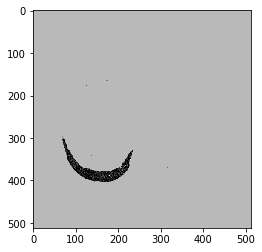

Predicted Y


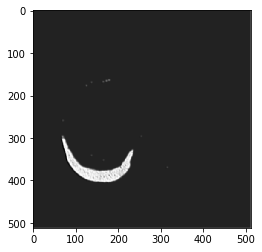

Probs Y


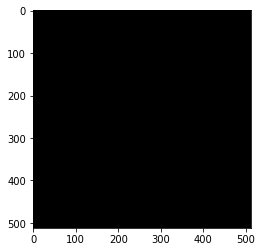

Actual Y


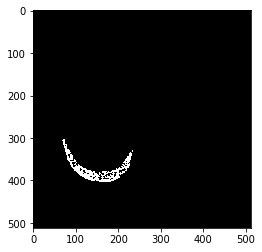

Checkpoint 50 saved !


In [10]:
net = UNet(1, 1)

try:
    all_losses = train_net(net) # , options.epochs, options.batchsize, options.lr,gpu=options.gpu)
    np.save('all_losses.pkl', all_losses)
except KeyboardInterrupt:
    torch.save(net.state_dict(), 'INTERRUPTED.pth')
    print('Saved interrupt')

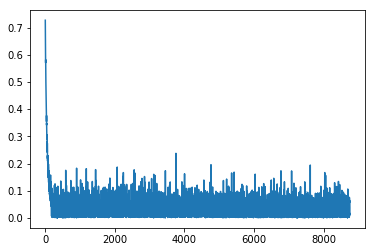

In [12]:
plt.plot(all_losses)
plt.show()